### Bag of Words

### helper.py

In [34]:
import cv2
import numpy as np 
from glob import glob
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

class ImageHelpers:
	def __init__(self):
		self.sift_object = cv2.xfeatures2d.SIFT_create()

	def gray(self, image):
		gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
		return gray

	def features(self, image):
		keypoints, descriptors = self.sift_object.detectAndCompute(image, None)
		return [keypoints, descriptors]


class BOVHelpers:
	def __init__(self, n_clusters = 20):
		self.n_clusters = n_clusters
		self.kmeans_obj = KMeans(n_clusters = n_clusters)
		self.kmeans_ret = None
		self.descriptor_vstack = None
		self.mega_histogram = None
		self.clf  = SVC()	
        
	def setClf(self, clf):
		self.clf=clf

	def cluster(self):
		"""	
		cluster using KMeans algorithm, 

		"""
		self.kmeans_ret = self.kmeans_obj.fit_predict(self.descriptor_vstack)

	def developVocabulary(self,n_images, descriptor_list, kmeans_ret = None):
		
		"""
		Each cluster denotes a particular visual word 
		Every image can be represeted as a combination of multiple 
		visual words. The best method is to generate a sparse histogram
		that contains the frequency of occurence of each visual word 

		Thus the vocabulary comprises of a set of histograms of encompassing
		all descriptions for all images

		"""

		self.mega_histogram = np.array([np.zeros(self.n_clusters) for i in range(n_images)])
		old_count = 0
		for i in range(n_images):
			l = len(descriptor_list[i])
			for j in range(l):
				if kmeans_ret is None:
					idx = self.kmeans_ret[old_count+j]
				else:
					idx = kmeans_ret[old_count+j]
				self.mega_histogram[i][idx] += 1
			old_count += l
		print("Vocabulary Histogram Generated")

	def standardize(self, std=None):
		"""
		
		standardize is required to normalize the distribution
		wrt sample size and features. If not normalized, the classifier may become
		biased due to steep variances.

		"""
		if std is None:
			self.scale = StandardScaler().fit(self.mega_histogram)
			self.mega_histogram = self.scale.transform(self.mega_histogram)
		else:
			print("STD not none. External STD supplied")
			self.mega_histogram = std.transform(self.mega_histogram)

	def formatND(self, l):
		"""	
		restructures list into vstack array of shape
		M samples x N features for sklearn

		"""
		print("l: ")
		print(l)
        
		vStack = np.array(l[0])
		for remaining in l[1:]:
			vStack = np.vstack((vStack, remaining))
		self.descriptor_vstack = vStack.copy()
		return vStack

	def train(self, train_labels):
		"""
		uses sklearn.svm.SVC classifier (SVM) 


		"""
		print("Training SVM")
		print(self.clf)
		print("Train labels", train_labels)
		self.clf.fit(self.mega_histogram, train_labels)
		print("Training completed")

	def predict(self, iplist):
		predictions = self.clf.predict(iplist)
		return predictions

	def plotHist(self, vocabulary = None):
		print("Plotting histogram")
		if vocabulary is None:
			vocabulary = self.mega_histogram

		x_scalar = np.arange(self.n_clusters)
		y_scalar = np.array([abs(np.sum(vocabulary[:,h], dtype=np.int32)) for h in range(self.n_clusters)])

		print(y_scalar)

		plt.bar(x_scalar, y_scalar)
		plt.xlabel("Visual Word Index")
		plt.ylabel("Frequency")
		plt.title("Complete Vocabulary Generated")
		plt.xticks(x_scalar + 0.4, x_scalar)
		plt.show()

class FileHelpers:

	def __init__(self):
		pass

	def getFiles(self, path):
		"""
		- returns  a dictionary of all files 
		having key => value as  objectname => image path

		- returns total number of files.

		"""
		imlist = {}
		count = 0
		for each in glob(path + "*"):
			each = each.replace("\\", "/")
			word = each.split("/")[-1]
			print(" #### Reading image category ", word, " ##### ")   
			imlist[word] = []
			for imagefile in glob(path+word+"/*"):
				print("Reading file ", imagefile)
				im = cv2.imread(imagefile, 0)
				imlist[word].append(im)
				count +=1 
		return [imlist, count]



### kmeans.py

[2 0 0 1 2 2 0 2 0 2 2 2 2 1 2 1 0 0 1 2 1 1 2 2 1 2 0 0 2 1 1 0 1 1 2 2 0
 1 2 1 2 1 2 2 1 2 0 1 1 0 0 0 1 2 1 2 1 1 0 1 0 2 0 1 1 2 0 0 1 0 2 0 2 2
 2 0 2 1 1 1 0 0 1 1 0 2 2 1 2 0 2 0 0 2 2 2 0 2 2 1 2 0 2 2 0 0 2 0 2 0 2
 1 2 0 0 1 0 1 0 1 1 0 1 0 1 1 1 0 0 2 2 2 2 1 1 1 0 0 2 2 2 1 0 2 1 2 0 2
 2 1 2 0 0 1 1 1 2 1 0 0 0 1 0 2 0 0 1 2 1 0 2 0 0 2 0 0 2 2 2 2 0 1 1 2 0
 2 2 0 0 2 1 1 0 1 2 1 2 1 1 2 1 0 1 2 2 1 1 2 2 2 1 0 0 2 0 2 2 2 0 0 2 0
 0 0 0 2 2 2 1 1 0 0 1 2 0 0 1 1 0 0 0 0 2 1 1 1 1 2 2 2 0 2 2 1 1 2 2 1 0
 0 1 0 0 2 2 2 1 1 0 0 2 1 0 2 1 0 1 1 2 0 2 1 1 2 2 2 1 0 2 2 0 2 0 1 1 2
 1 1 0 0 2 0 2 0 2 0 2 2 0 0 2 0 0 0 1 2 0 0 1 1 0 0 2 0 0 0 1 1 2 1 2 0 0
 1 0 1 1 1 0 2 1 1 0 0 0 1 2 0 1 0 0 2 1 1 1 0 2 2 1 0 0 0 0 2 1 2 2 0 2 1
 1 1 1 1 1 2 1 1 2 1 2 0 1 0 0 1 0 1 1 0 1 2 2 2 0 0 1 1 0 2 0 1 1 1 0 2 0
 1 0 1 1 0 0 1 2 2 2 1 1 0 1 0 0 1 2 1 1 1 1 1 0 2 2 2 2 2 0 2 1 1 0 1 2 0
 2 0 1 0 1 1 1 1 1 0 0 2 2 1 1 1 1 2 0 0 1 2 2 0 1 2 0 0 1 2 2 0 0 2 1 0 0
 1 0 0 0 1 0 2 2 0 2 0 2 

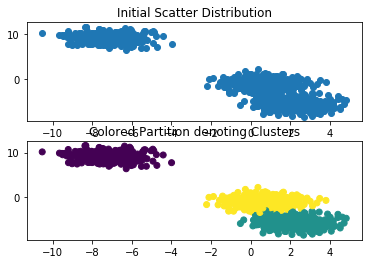

In [26]:
"""
Using SKLearns API for performing Kmeans clustering.
Using sklearn.datasets.make_blobs for generating randomized gaussians
for clustering.

"""

import numpy as np 
from matplotlib import pyplot as plt 
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs 

# create a dataset sample space that will be used
# to test KMeans. Use function : make_blobs
# 

n_samples = 1000
n_features = 5;
n_clusters = 3;

# aint this sweet 
X, y = make_blobs(n_samples, n_features) 
# X => array of shape [nsamples,nfeatures] ;;; y => array of shape[nsamples]

# X : generated samples, y : integer labels for cluster membership of each sample
# 
# 

# performing KMeans clustering

ret =  KMeans(n_clusters = n_clusters).fit_predict(X)
print(ret)

__, ax = plt.subplots(2)
ax[0].scatter(X[:,0], X[:,1])
ax[0].set_title("Initial Scatter Distribution")
ax[1].scatter(X[:,0], X[:,1], c=ret)
ax[1].set_title("Colored Partition denoting Clusters")
# plt.scatter
plt.show()



### Bag.py

In [49]:
import cv2
import numpy as np 
from glob import glob 
import argparse
#from helpers import *
from matplotlib import pyplot as plt 


class BOV:
    def __init__(self, no_clusters):
        self.no_clusters = no_clusters
        self.train_path = None
        self.test_path = None
        self.im_helper = ImageHelpers()
        self.bov_helper = BOVHelpers(no_clusters)
        self.file_helper = FileHelpers()
        self.images = None
        self.trainImageCount = 0
        self.train_labels = np.array([])
        self.name_dict = {}
        self.name_dict_reverse = {}
        self.descriptor_list = []
        
    def setClf(self, clf):
        self.bov_helper.setClf(clf)
        
    def trainModel(self):
        """
        This method contains the entire module 
        required for training the bag of visual words model

        Use of helper functions will be extensive.

        """

        # read file. prepare file lists.
        self.images, self.trainImageCount  = self.file_helper.getFiles(self.train_path)
        
        # extract SIFT Features from each image
        print("images: ", self.images)
        print("train image count: ", self.trainImageCount)
        label_count = 0 
        for word, imlist in self.images.items():
            self.name_dict[str(label_count)] = word
            self.name_dict_reverse[word] = label_count
            print("Computing Features for ", word)
            print("List: ", imlist)
            for im in imlist:
                # cv2.imshow("im", im)
                # cv2.waitKey()
                self.train_labels = np.append(self.train_labels, label_count)
                kp, des = self.im_helper.features(im)
                self.descriptor_list.append(des)

            label_count += 1
            
        


        # perform clustering
        
        print(self.descriptor_list)
        bov_descriptor_stack = self.bov_helper.formatND(self.descriptor_list)
        self.bov_helper.cluster()
        self.bov_helper.developVocabulary(n_images = self.trainImageCount, descriptor_list=self.descriptor_list)

        # show vocabulary trained
        # self.bov_helper.plotHist()
 

        self.bov_helper.standardize()
        self.bov_helper.train(self.train_labels)
        print("trainModel DONE.")


    def recognize(self,test_img, test_image_path=None):

        """ 
        This method recognizes a single image 
        It can be utilized individually as well.


        """

        kp, des = self.im_helper.features(test_img)
        # print kp
        print(des.shape)

        # generate vocab for test image
        vocab = np.array( [[ 0 for i in range(self.no_clusters)]])
        # locate nearest clusters for each of 
        # the visual word (feature) present in the image
        
        # test_ret =<> return of kmeans nearest clusters for N features
        test_ret = self.bov_helper.kmeans_obj.predict(des)
        # print test_ret

        # print vocab
        for each in test_ret:
            vocab[0][each] += 1

        print(vocab)
        # Scale the features
        vocab = self.bov_helper.scale.transform(vocab)

        # predict the class of the image
        lb = self.bov_helper.clf.predict(vocab)
        # print "Image belongs to class : ", self.name_dict[str(int(lb[0]))]
        return lb



    def testModel(self):
        """ 
        This method is to test the trained classifier

        read all images from testing path 
        use BOVHelpers.predict() function to obtain classes of each image

        """
        wordlist=[]
        self.testImages, self.testImageCount = self.file_helper.getFiles(self.test_path)
        
        predictions = []
        correct_labels = []
        for word, imlist in self.testImages.items():
            print("processing " ,word)
            for im in imlist:
                # print imlist[0].shape, imlist[1].shape
                correct_labels.append(self.name_dict_reverse[word])
                print(im.shape)
                cl = self.recognize(im)
                print(cl)
                predictions.append({
                    'image':im,
                    'class':cl,
                    'object_name':self.name_dict[str(int(cl[0]))]
                    })

        print(predictions)
        print("CORRECT LABELS:",correct_labels)
        for each in predictions:
            # cv2.imshow(each['object_name'], each['image'])
            # cv2.waitKey()
            # cv2.destroyWindow(each['object_name'])
            # 
            plt.imshow(cv2.cvtColor(each['image'], cv2.COLOR_GRAY2RGB))
            plt.title(each['object_name'])
            plt.show()


    def print_vars(self):
        pass
    
    def start(self, train_path, test_path):
        # set training paths
        self.train_path = train_path
        # set testing paths
        self.test_path = test_path
        # train the model
        self.trainModel()
        # test model
        self.testModel()


# if __name__ == '__main__':

#     # parse cmd args
#     parser = argparse.ArgumentParser(
#             description=" Bag of visual words example"
#         )
#     parser.add_argument('--train_path', action="store", dest="train_path", required=True)
#     parser.add_argument('--test_path', action="store", dest="test_path", required=True)

#     args =  vars(parser.parse_args())
#     print(args)

    
#     bov = BOV(no_clusters=100)

#     # set training paths
#     bov.train_path = args['train_path'] 
#     # set testing paths
#     bov.test_path = args['test_path'] 
#     # train the model
#     bov.trainModel()
#     # test model
#     bov.testModel()


 #### Reading image category  accordion  ##### 
Reading file  images/train/accordion\image_0001.jpg
Reading file  images/train/accordion\image_0002.jpg
Reading file  images/train/accordion\image_0003.jpg
Reading file  images/train/accordion\image_0007.jpg
Reading file  images/train/accordion\image_0008.jpg
Reading file  images/train/accordion\image_0009.jpg
Reading file  images/train/accordion\image_0010.jpg
Reading file  images/train/accordion\image_0011.jpg
Reading file  images/train/accordion\image_0012.jpg
Reading file  images/train/accordion\image_0013.jpg
Reading file  images/train/accordion\image_0014.jpg
Reading file  images/train/accordion\image_0016.jpg
Reading file  images/train/accordion\image_0018.jpg
Reading file  images/train/accordion\image_0021.jpg
 #### Reading image category  dollar_bill  ##### 
Reading file  images/train/dollar_bill\image_0001.jpg
Reading file  images/train/dollar_bill\image_0002.jpg
Reading file  images/train/dollar_bill\image_0003.jpg
Reading file

Computing Features for  dollar_bill
List:  [array([[53, 49, 46, ..., 60, 55, 51],
       [48, 48, 49, ..., 56, 51, 48],
       [43, 47, 51, ..., 56, 52, 50],
       ...,
       [44, 47, 46, ..., 49, 49, 49],
       [45, 49, 50, ..., 49, 49, 49],
       [45, 51, 52, ..., 49, 49, 49]], dtype=uint8), array([[255, 245, 238, ..., 225, 225, 224],
       [241, 249, 255, ..., 229, 228, 228],
       [247, 244, 242, ..., 234, 233, 232],
       ...,
       [253, 253, 250, ..., 227, 225, 224],
       [252, 253, 252, ..., 233, 231, 229],
       [247, 248, 248, ..., 233, 232, 230]], dtype=uint8), array([[240, 247, 245, ..., 231, 232, 231],
       [245, 249, 247, ..., 236, 235, 231],
       [244, 248, 247, ..., 231, 230, 227],
       ...,
       [251, 252, 252, ..., 233, 230, 228],
       [251, 252, 252, ..., 227, 224, 222],
       [251, 252, 252, ..., 223, 221, 219]], dtype=uint8), array([[248, 246, 255, ..., 255, 255, 255],
       [246, 224, 246, ..., 255, 255, 255],
       [248, 237, 251, ..., 255

[array([[91., 20.,  0., ..., 28.,  0.,  0.],
       [ 1.,  1.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  3.,  2., 12.],
       ...,
       [11., 15., 69., ...,  0.,  0.,  4.],
       [ 0.,  0.,  0., ..., 46., 18.,  9.],
       [42., 18., 35., ...,  3.,  1., 12.]], dtype=float32), array([[  4.,  11.,   0., ...,  26.,  33.,  46.],
       [  0.,  10.,  50., ..., 121.,  66.,   5.],
       [  2.,   5.,  63., ...,   0.,   0.,   0.],
       ...,
       [  6.,   1.,   0., ...,   0.,   4., 143.],
       [  9.,   3.,   3., ...,   2.,   2.,  65.],
       [ 34.,   4.,   0., ...,   5.,   4.,   0.]], dtype=float32), array([[ 0.,  0.,  0., ...,  1.,  1.,  1.],
       [17., 21., 38., ...,  1.,  0.,  1.],
       [ 0.,  2., 14., ...,  0.,  0.,  0.],
       ...,
       [62.,  5.,  1., ...,  0.,  0.,  0.],
       [28.,  3.,  4., ...,  2., 11., 21.],
       [ 2.,  1.,  2., ...,  0.,  0.,  1.]], dtype=float32), array([[ 24.,   5.,   0., ...,   0.,   1.,   1.],
       [146.,  25.,   0., ...,  12

Vocabulary Histogram Generated
Training SVM
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
Train labels [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3.]
Training completed
trainModel DONE.
 #### Reading image category  accordion  ##### 
Reading file  images/test/accordion\image_0023.jpg
Reading file  images/test/accordion\image_0026.jpg
 #### Reading image category  dollar_bill  ##### 
Reading file  images/test/dollar_bill\image_0040.jpg
Reading file  images/test/dollar_bill\image_0048.jpg
 #### Reading image category  motorbike  ##### 
Reading file  images/test/motorbike\image_0030.jpg
Reading file  images/test/motorbike\image_0044.jpg
 #### Reading image category  Soccer_Ball  

D:\Programme\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
D:\Programme\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
D:\Programme\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
D:\Programme\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
D:\Programme\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float6


[[ 6  9  0  5  6  3  5  3  3  2  1  2  0  4  0  2  2  0  2  1  0  1  6 10
   2  6  3  6  6  2  1  2  4  3  3  6  4  5  3  3  1  5  8  1  1  3  6  4
   6  1  0  4  8  4  0  2  4  2  4  3  5 10  0  0  1  1  5  5  7  2  1  0
   0  4  2  7  2  1  6  2  2  5  3  0  3  5  5  2  3  3  4  6  1  5  4  5
   4  8  5  3]]
[2.]
(172, 269)
(206, 128)
[[3 2 2 4 4 2 1 4 2 7 2 3 0 5 0 1 3 2 0 1 0 0 3 4 0 2 1 2 3 1 1 2 3 4 0 1
  6 1 0 2 0 2 1 2 1 0 1 3 2 0 0 2 0 2 1 3 1 0 3 6 2 2 1 1 7 2 3 1 1 0 1 3
  2 1 1 3 4 1 2 0 3 2 0 1 2 2 1 3 3 1 3 2 0 4 5 5 6 4 2 5]]
[2.]
processing  Soccer_Ball
(300, 279)
(227, 128)
[[ 8  2  0  0 37  0  0  0  0  0  0  1  0  0  0  0  2  0  0  0  0  0  2  2
   1  0  1  0  4  0  0  1  0  0  0  4  5  0 17  7  0  0  0  1  0  1  0  0
   0  0  5  0 33  1  0  5  0  0  0  1  1  3  0  1  0  0  1  3  7  1  0  0
   0  1  1  1  0  0 23  0  1  0  2  0  2  0  0  8  0  0  2  0  0  0  0  3
   0  8 13  4]]
[3.]
(225, 300)
(90, 128)
[[ 5  2  3  0  3  0  1  2  0  0  0  0  0  3  1  1  2  0  2  1  

D:\Programme\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
D:\Programme\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
D:\Programme\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


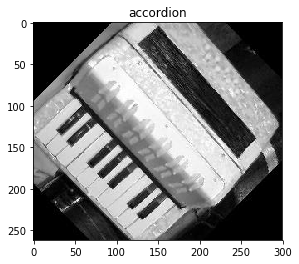

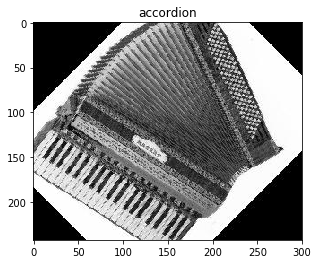

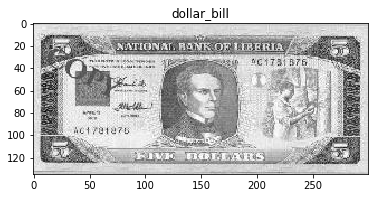

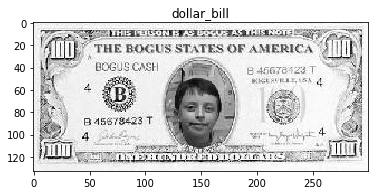

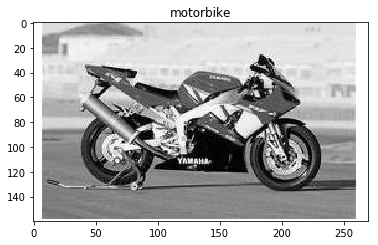

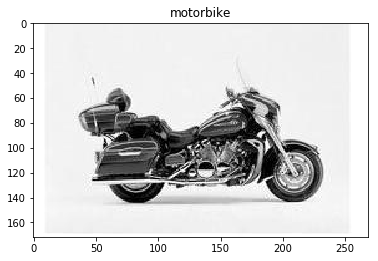

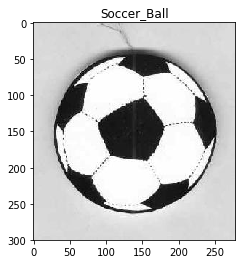

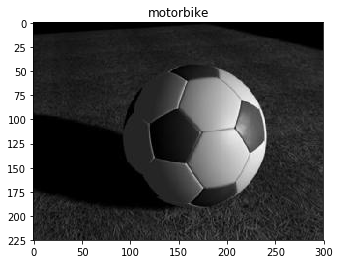

In [50]:
bov = BOV(no_clusters=100)
#clf=MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
#bov.setClf(clf)
bov.start("images/train/", "images/test/")
